#### First build the hybrid graph.
library(future)
source("../graph_build/data_preprocess_utility_PCA.R")
source("../graph_build/filter_PCA.R")
plan(strategy = "multicore")
options(future.globals.maxSize = 100000 * 1024^14)

count <- readRDS("../../data/human40k/count.list.rds")
label <- readRDS("../../data/human40k/label.list.rds")

save_processed_data(count, label, dir = "../../data/human40k/input", K_inter = 50, K_intra = 10,n_gene=5000, dim = 50)
fix_index("../../data/human40k/input")
acc_intra_graph1("../../data/human40k/input")
filter4_weight("../../data/human40k/input")

In [1]:
import argparse
import sys
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import subgraph
from torch_scatter import scatter
import dataset
from dataset import input_dataset
from utils import read_data, scGT_output
from parse import parse_method
from train import model_train
from plot import umap_emb
from scGT import *
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [2]:
parser = argparse.ArgumentParser()
default_args = {
    'dataset': 'data',
    'data_dir': '../data/human40k/', 
    'device': 0, 
    'seed': 42, 
    'maxepochs': 5000,
    'eval_step': 10,
    'model_dir': '../model/', 
    'hidden_channels': 128,
    'lr': 5e-5,              
    'weight_decay': 1e-2,
    'lamda1': 0.1,          
    'lamda2': 0.1,          
    'num_batch': 1,          
    'early_stop':30,        
    'is_move': True         
}
"""
'data_dir': Input path
'model_dir': Model storage path
'seed': Seed
'lr': Learning rate
'lamda1': Hard regularity relaxation coefficient
'lamda2': Query graph regularity relaxation coefficient
'num_batch': How many subgraphs to create. If the GPU allows, it's best to be as small as possible
'early_stop': Early stop epoch
'is_move': Whether move query data to reference if confidence score > 0.95
"""


args = argparse.Namespace(**default_args)
print(args)

fix_seed(args.seed)
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

Namespace(data_dir='../data/human40k/', dataset='data', device=0, early_stop=30, eval_step=10, hidden_channels=128, is_move=True, lamda1=0.1, lamda2=0.1, lr=5e-05, maxepochs=5000, model_dir='../model/', num_batch=1, seed=42, weight_decay=0.01)


In [3]:
%%time
import time

### Load and preprocess data ###
dataset = input_dataset(args.data_dir, args.dataset)
dataset, x, n, c, d, split_idx, adjs, adj_loss_inter, adj_loss_intra2 = read_data(args, dataset)

num nodes 40000 | num edges 283690 | num classes 54 | num node feats 22123
CPU times: user 36 s, sys: 21.2 s, total: 57.2 s
Wall time: 42.6 s


In [4]:
### Load method ###
model = parse_method(args, dataset, n, c, d, device)
model.train()
print('MODEL:', model)

MODEL: scGT(
  (convs): ModuleList(
    (0-1): 2 x NodeFormerConv(
      (Wk): Linear(in_features=128, out_features=128, bias=True)
      (Wq): Linear(in_features=128, out_features=128, bias=True)
      (Wv): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=22123, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=54, bias=True)
  )
  (bns): ModuleList(
    (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
)


In [5]:
### Train ###
model_train(args, dataset, model, split_idx, device, x, n, adjs, adj_loss_inter, adj_loss_intra2)

Epoch: 00, Loss: 6.6942, Cross Entropy Loss: 4.1532, Hard regularity: 1.6778, Query Graph regularity: 0.8633, Reference: 4.36% 
Epoch: 10, Loss: 3.9130, Cross Entropy Loss: 2.8595, Hard regularity: 0.6129, Query Graph regularity: 0.4407, Reference: 53.52% 
Epoch: 20, Loss: 2.8790, Cross Entropy Loss: 2.2550, Hard regularity: 0.3394, Query Graph regularity: 0.2846, Reference: 77.41% 
Epoch: 30, Loss: 2.2140, Cross Entropy Loss: 1.7001, Hard regularity: 0.3162, Query Graph regularity: 0.1977, Reference: 88.78% 
Epoch: 40, Loss: 1.7544, Cross Entropy Loss: 1.2433, Hard regularity: 0.3322, Query Graph regularity: 0.1789, Reference: 93.60% 
Epoch: 50, Loss: 1.3943, Cross Entropy Loss: 0.9100, Hard regularity: 0.3279, Query Graph regularity: 0.1565, Reference: 96.47% 
Epoch: 60, Loss: 1.1260, Cross Entropy Loss: 0.7027, Hard regularity: 0.2895, Query Graph regularity: 0.1338, Reference: 97.89% 
Epoch: 70, Loss: 0.9235, Cross Entropy Loss: 0.5677, Hard regularity: 0.2434, Query Graph regulari

In [6]:
### umap_emb ###
embedding_umap, label, pre, tech = umap_emb(args, model, dataset, x, adjs)

{0: 'Acinar cells', 1: 'Adrenocortical cells', 2: 'Antigen presenting cells', 3: 'Astrocytes', 4: 'Bronchiolar and alveolar epithelial cells', 5: 'Cardiomyocytes', 6: 'Chromaffin cells', 7: 'Ciliated epithelial cells', 8: 'Ductal cells', 9: 'ENS glia', 10: 'ENS neurons', 11: 'Endocardial cells', 12: 'Epicardial fat cells', 13: 'Erythroblasts', 14: 'Excitatory neurons', 15: 'Extravillous trophoblasts', 16: 'Ganglion cells', 17: 'Goblet cells', 18: 'Granule neurons', 19: 'Hematopoietic stem cells', 20: 'Hepatoblasts', 21: 'IGFBP1_DKK1 positive cells', 22: 'Inhibitory neurons', 23: 'Intestinal epithelial cells', 24: 'Islet endocrine cells', 25: 'Limbic system neurons', 26: 'Lymphatic endothelial cells', 27: 'Lymphoid cells', 28: 'Megakaryocytes', 29: 'Mesangial cells', 30: 'Mesothelial cells', 31: 'Metanephric cells', 32: 'Myeloid cells', 33: 'Neuroendocrine cells', 34: 'PAEP_MECOM positive cells', 35: 'Parietal and chief cells', 36: 'Photoreceptor cells', 37: 'Purkinje neurons', 38: 'Ret

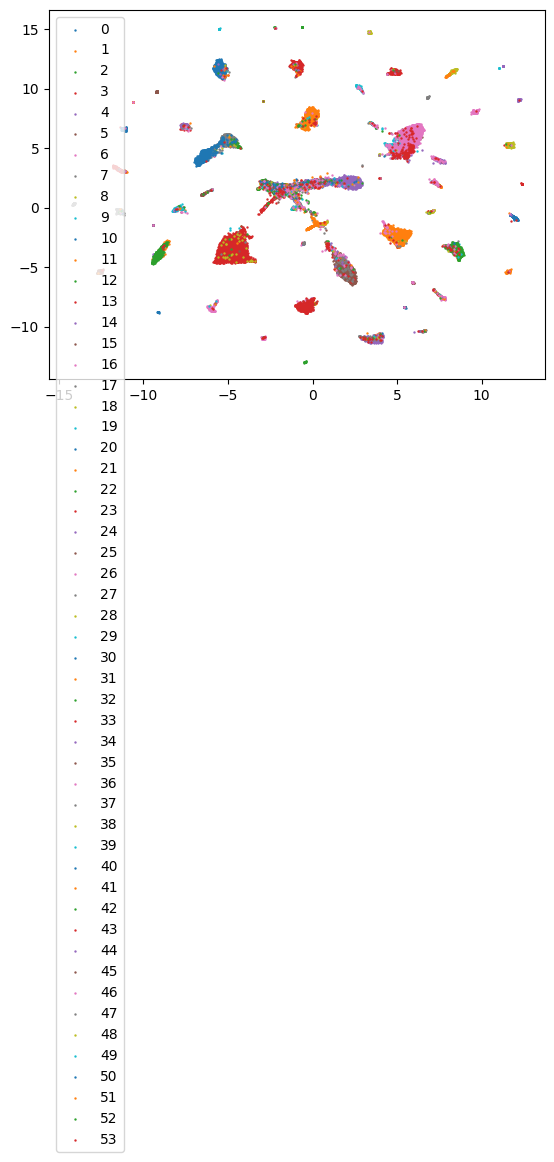

In [7]:
# celltype
%matplotlib inline
labels = np.unique(label)
for i in labels:
    plt.scatter(embedding_umap[label == i, 0], embedding_umap[label == i, 1], s=0.5, label=str(i))
plt.legend()
plt.show()

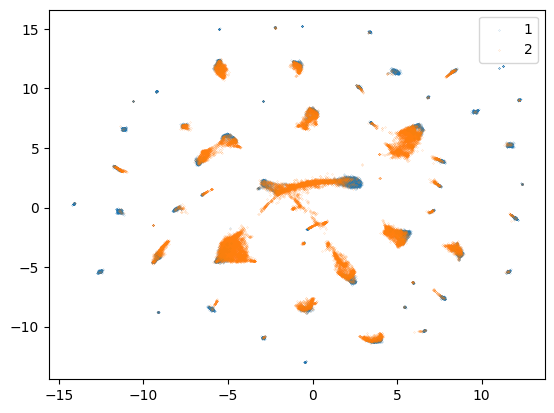

In [8]:
# tech
%matplotlib inline
techs = np.unique(tech) 
for i in techs:
    plt.scatter(embedding_umap[tech == i, 0], embedding_umap[tech == i, 1], s=0.01, label=str(i))
plt.legend()
plt.show()